In [1]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
import os
import numpy as np
import requests

# Download the required files.

def download_file(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful.
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")


In [3]:
import os
import sys
import torch
import torchvision.models as models


def load_model_for_binary_classification(model_name='googlenet', model_dir='../../data/external/Places365/model'):
    os.makedirs(model_dir, exist_ok=True)

    if model_name == 'googlenet':
        model_file = os.path.join(model_dir, 'googlenet_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/googlenet_places365.pth'
    elif model_name == 'alexnet':
        model_file = os.path.join(model_dir, 'alexnet_places365.pth')
        model_url = 'http://places2.csail.mit.edu/models_places365/alexnet_places365.pth'
    else:
        raise ValueError(f"Model {model_name} not supported.")

    if not os.path.exists(model_file):
        print(f"{model_file} does not exist. Downloading...")
        download_file(model_url, model_file)

    if model_name == 'googlenet':
        model = models.googlenet(num_classes=365)
    elif model_name == 'alexnet':
        model = models.alexnet(num_classes=365)

    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
    state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)

    if model_name == 'alexnet':
        model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
    elif model_name == 'googlenet':
        model.fc = torch.nn.Linear(model.fc.in_features, 2)

    print(f"Model {model_name} for binary classification loaded successfully.")
    return model

# model = load_model_for_binary_classification(model_name='vgg16')
# model = load_model_for_binary_classification(model_name='googlenet')
# model = load_model_for_binary_classification(model_name='alexnet')


In [4]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        self.label = self.data_frame['landscape']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0]) 
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [5]:
data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

data = pd.read_csv(data_path)

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

image_dataset = LandscapesDataset(data_frame=data,
                              root_dir=image_folder,
                              transform=data_transforms)

train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")


Training set size: 4000
Validation set size: 1000


In [6]:
model = load_model_for_binary_classification(model_name='alexnet')

Model alexnet for binary classification loaded successfully.


Epoch 1/10: 100%|█████████████████| 125/125 [02:15<00:00,  1.08s/it, loss=0.525]

Epoch 1/10, Training Loss: 0.6833


Epoch 1/10, Validation Loss: 0.5848


Epoch 2/10: 100%|█████████████████| 125/125 [02:11<00:00,  1.06s/it, loss=0.726]

Epoch 2/10, Training Loss: 0.5709


Epoch 2/10, Validation Loss: 0.5832


Epoch 3/10: 100%|█████████████████| 125/125 [02:14<00:00,  1.07s/it, loss=0.572]

Epoch 3/10, Training Loss: 0.5323


Epoch 3/10, Validation Loss: 0.4933


Epoch 4/10: 100%|█████████████████| 125/125 [02:16<00:00,  1.09s/it, loss=0.501]

Epoch 4/10, Training Loss: 0.5327


Epoch 4/10, Validation Loss: 0.5312


Epoch 5/10: 100%|██████████████████| 125/125 [02:15<00:00,  1.08s/it, loss=0.42]

Epoch 5/10, Training Loss: 0.5400


Epoch 5/10, Validation Loss: 0.5415


Epoch 6/10: 100%|██████████████████| 125/125 [02:14<00:00,  1.07s/it, loss=0.36]

Epoch 6/10, Training Loss: 0.5154


Epoch 6/10, Validation Loss: 0.5412


Epoch 7/10: 100%|██████████████████| 125/125 [02:15<00:00,  1.09s/it, loss=0.42]

Epoch 7/10, Training Loss: 0.5089


Epoch 7/10, Validation Loss: 0.5091


Epoch 8/10: 100%|█████████████████| 125/125 [02:15<00:00,  1.08s/it, loss=0.441]

Epoch 8/10, Training Loss: 0.4644


Epoch 8/10, Validation Loss: 0.4895


Epoch 9/10: 100%|█████████████████| 125/125 [02:15<00:00,  1.08s/it, loss=0.447]

Epoch 9/10, Training Loss: 0.4297


Epoch 9/10, Validation Loss: 0.4898


Epoch 10/10: 100%|████████████████| 125/125 [02:13<00:00,  1.07s/it, loss=0.455]

Epoch 10/10, Training Loss: 0.4196


Epoch 10/10, Validation Loss: 0.4607


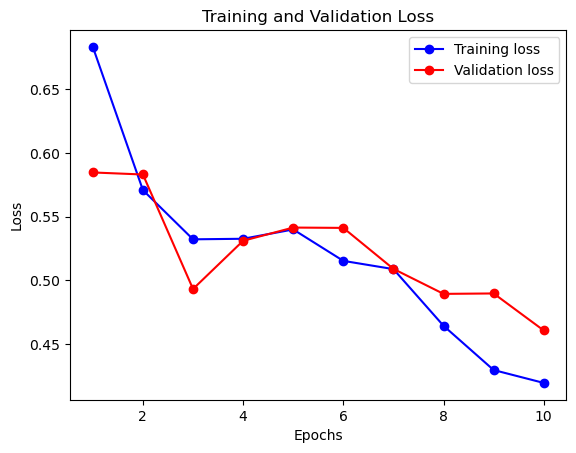

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        total_batches = len(train_loader)
        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, labels) in progress_bar:
            images, labels = torch.stack(images), torch.stack(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = torch.stack(images), torch.stack(labels)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        scheduler.step()
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses, model

train_losses, val_losses, model = train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

torch.save(model.state_dict(), 'places365_binary_model_alexnet.pth')

def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

In [11]:
model_name = input('Please enter the name of model: ')

if model_name == 'alexnet':
    model = models.alexnet(weights=None)
    model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 2)
elif model_name == "resnet":
    model = models.resnet(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
else:
    model = models.googlenet(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('../../models/places365_binary_model_alexnet.pth', map_location='cpu', weights_only=True))
model.eval()


data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes_test.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

data = pd.read_csv(data_path)

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])


# sampled_data = data.sample(n=100, random_state=123) 
image_paths = data.iloc[:, 0].tolist()
true_labels = data.iloc[:, 1].tolist()

from collections import Counter

label_counts = Counter(true_labels)

total_samples = len(true_labels)
label_ratios = {label: count / total_samples for label, count in label_counts.items()}

for label, ratio in label_ratios.items():
    print(f"Label: {label}, Count: {label_counts[label]}, Ratio: {ratio * 100:.2f}%")

predictions = []

incorrect_images = []

for img_path, true_label in tqdm(zip(image_paths, true_labels), total=len(image_paths), desc="Processing images"):

    image_path = os.path.join(image_folder, img_path) 
    
    img = data_transforms(Image.open(image_path).convert('RGB')) .unsqueeze(0)
    
    with torch.no_grad():
        output = model(img)
    
    _, predicted = torch.max(output, 1)
    predictions.append(predicted.item())

    if predicted.item() != true_label:
        incorrect_images.append((image_path, true_label, predicted.item()))

accuracy = accuracy_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='macro')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(confusion_matrix(true_labels, predictions))

Please enter the name of model:  alexnet


Label: 1.0, Count: 58, Ratio: 58.00%
Label: 0.0, Count: 42, Ratio: 42.00%


Processing images: 100%|██████████████████████| 100/100 [00:12<00:00,  8.32it/s]

Accuracy: 77.00%
Recall: 77.55%
[[34  8]
 [15 43]]
